<a href="https://colab.research.google.com/github/sujialagar/Tomato-Classification/blob/main/Tomato_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets --upgrade --quiet
!pip install jovian --upgrade --quiet

In [ ]:
import pandas as pd
import os
import jovian
import opendatasets as od

In [ ]:
# Assign the Kaggle data set URL into variable
dataset = 'https://www.kaggle.com/datasets/enalis/tomatoes-dataset'
# Using opendatasets let's download the data sets
od.download(dataset)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ranjanisiva
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/enalis/tomatoes-dataset


100%|██████████| 93.7M/93.7M [00:02<00:00, 48.7MB/s]


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_gen = datagen.flow_from_directory('/content/tomatoes-dataset/content/ieee-mbl-cls/train',
                                        target_size=(224, 224),
                                        batch_size=32,
                                        class_mode='categorical',
                                        subset='training')
val_gen = datagen.flow_from_directory('/content/tomatoes-dataset/content/ieee-mbl-cls/val',
                                      target_size=(224, 224),
                                      batch_size=32,
                                      class_mode='categorical',
                                      subset='validation')


Found 5202 images belonging to 4 classes.
Found 144 images belonging to 4 classes.


In [ ]:
#data augmentation
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2,
                                   rotation_range=20, # rotate images by 20 degrees
                                   width_shift_range=0.2, # shift images horizontally
                                   height_shift_range=0.2, # shift images vertically
                                   shear_range=0.2, # shear images
                                   zoom_range=0.2, # zoom in/out
                                   horizontal_flip=True, # flip images horizontally
                                   fill_mode='nearest') # fill in missing pixels

train_gen = train_datagen.flow_from_directory('/content/tomatoes-dataset/content/ieee-mbl-cls/train',
                                        target_size=(224, 224),
                                        batch_size=32,
                                        class_mode='categorical',
                                        subset='training')

Found 5202 images belonging to 4 classes.


In [ ]:
#model architecture
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # 4 classes: Ripe, Unripe, Old, Damaged
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
#Attention mechanism
from tensorflow.keras.layers import Attention

def build_model_with_attention(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Apply attention
    attention = Attention()([x, x])

    x = Conv2D(64, (3, 3), activation='relu')(attention)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(4, activation='softmax')(x)

    return Model(inputs, outputs)


In [ ]:
#compile model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
#training the model
history = model.fit(train_gen, validation_data=val_gen, epochs=25)

Epoch 1/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 62s 365ms/step - accuracy: 0.8299 - loss: 0.4338 - val_accuracy: 0.8194 - val_loss: 0.4751
Epoch 2/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 83s 370ms/step - accuracy: 0.8355 - loss: 0.4335 - val_accuracy: 0.8889 - val_loss: 0.3280
Epoch 3/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 64s 378ms/step - accuracy: 0.8373 - loss: 0.4133 - val_accuracy: 0.8819 - val_loss: 0.2846
Epoch 4/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 63s 370ms/step - accuracy: 0.8328 - loss: 0.4240 - val_accuracy: 0.8681 - val_loss: 0.3480
Epoch 5/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 81s 361ms/step - accuracy: 0.8582 - loss: 0.3699 - val_accuracy: 0.8819 - val_loss: 0.4406
Epoch 6/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 63s 365ms/step - accuracy: 0.8429 - loss: 0.4026 - val_accuracy: 0.8750 - val_loss: 0.3650
Epoch 7/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 64s 378ms/step - accuracy: 0.8547 - loss: 0.3932 - val_accuracy: 0.8889 - val_loss: 0.3389
Epoch 8/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 63s 370ms/step - accuracy: 0.8605 - loss: 0

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

val_predictions = model.predict(val_gen)
val_labels = val_gen.classes

# Define class_names with the actual names of your classes
class_names = ['Ripe', 'Unripe', 'Old', 'Damaged']

report = classification_report(val_labels, val_predictions.argmax(axis=1), target_names=class_names)
print(report)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
              precision    recall  f1-score   support

        Ripe       0.09      0.05      0.06        21
      Unripe       0.31      0.36      0.34        44
         Old       0.33      0.32      0.33        44
     Damaged       0.38      0.43      0.40        35

    accuracy                           0.32       144
   macro avg       0.28      0.29      0.28       144
weighted avg       0.30      0.32      0.31       144



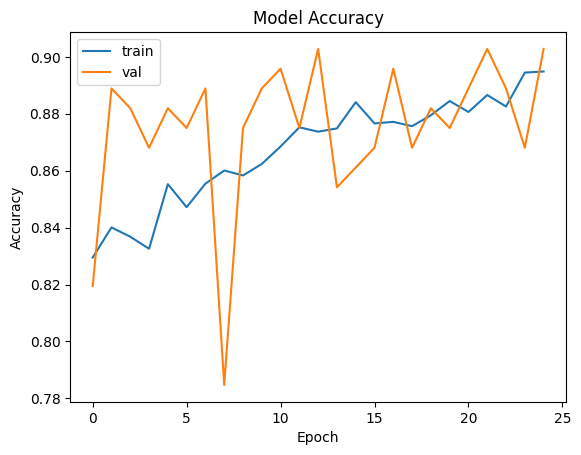

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()